# <u>An Analysis on Vivendo Fast Food Claims Process in Brazil</u>

### Company Background
Vivendo is a fast food chain in Brazil with over 200 outlets. As with many fast food establishments, customers make claims against the company. For example, they blame Vivendo for suspected food poisoning. The legal team, who processes these claims, is currently split across four locations. The new head of the legal department wants to see if there are differences in the time it takes to close claims across the locations. The legal team has given you a data set where each row is a claim made against the company. 

### Dataset
The dataset contains one row for each claim. This table contains a description of each of claims' columns and will be useful to correctly interpret the data.

|Column Name            | Criteria                                                                                                                              |    
|-----------------------|---------------------------------------------------------------------------------------------------------------------------------------|
|Claim ID               |Character, the unique identifier of the claim.                                                                                         |
|Time to Close          |Numeric, number of days it took for the claim to be closed.                                                                            |
|Claim Amount           |Numeric, initial claim value in the currency of Brazil. For example, “R$50,000.00” should be converted into 50000.                     |
|Amount Paid            |Numeric, total amount paid after the claim closed in the currency of Brazil.                                                           |
|Location               |Character, location of the claim, one of “RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”.                                                |
|Individuals on Claim   |Numeric, number of individuals on this claim.                                                                                          |
|Linked Cases           |Binary, whether this claim is believed to be linked with other cases, either TRUE or FALSE.                                            |
|Cause                  |Character, the cause of the food poisoning injuries, one of ‘vegetable’, ‘meat’, or ‘unknown’. Replace any empty rows with ‘unknown’.  |

### <b>📌Customer Question:</b>
They would like you to answer the following questions:
- <b>How does the number of claims differ across locations?</b>
- <b>What is the distribution of time to close claims?</b>
- <b>How does the average time to close claims differ by location?</b>

Let's start by loading all the necessary Python packages

In [364]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load Dataframe

In [365]:
# Preview the first rows of our dataset
claims = pd.read_csv(r'./claims.csv')
claims.head()

,Claim ID,Time to Close,Claim Amount,Amount Paid,Location,Individuals on Claim,Linked Cases,Cause
0,0000000-00.2010.0.00.0094,2082,"R$50,000.00",34297.47,RECIFE,2,False,NaN
1,0000000-00.2011.0.00.0086,3591,"R$180,000.00",56383.54,SAO LUIS,7,False,NaN
2,0000000-00.2012.0.00.0092,2997,"R$70,000.00",12366.76,SAO LUIS,3,False,vegetables
3,0000000-00.2013.0.00.0096,1143,"R$95,104.00",29217.16,FORTALEZA,4,False,NaN
4,0000000-00.2014.0.00.0097,117,"R$29,000.00",12610.50,FORTALEZA,1,False,meat


### <u>Exploratory Data Analysis</u>

In [366]:
# Quick overall glimpse at our data
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Claim ID              98 non-null     object 
 1   Time to Close         98 non-null     int64  
 2   Claim Amount          98 non-null     object 
 3   Amount Paid           98 non-null     float64
 4   Location              98 non-null     object 
 5   Individuals on Claim  98 non-null     int64  
 6   Linked Cases          98 non-null     bool   
 7   Cause                 20 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 5.6+ KB


We have 98 rows and 8 columns and only the Cause column contains NaN or null values - 78 to be exact. Now lets check if we have any duplicates in the dataset by using the unique identifier (Claim ID)

In [367]:
dupes = claims[claims.duplicated(['Claim ID'])]
print(len(dupes))

0


There are no duplicates in our data. 

### a. Data Cleaning and Validation

Lets begin cleaning and validating our data. Based on our table description above, the rows with inconsistencies is the Cause and Claim Amount columns. The Claim Amount column is currently an object data-type column but should be a numeric data-type and the Cause column contains null values. 

Lets begin by first changing the null values we identified to 'unknown' since these are unidentified food poisoning causes for each claim.

In [368]:
claims['Cause'].fillna('unknown', inplace=True)
claims.Cause.value_counts()

unknown       78
meat          12
vegetables     8
Name: Cause, dtype: int64

We have successfully replaced our null values and confirmed the number to still be 78 unknown values while getting a glimpse of our other values in the Cause column; 12 claims were cause by meat and 8 by vegetables

Lets clean the Claim Amount column by running a loop on each column value. We do this by creating a dictionary with our replacements, which in this case are empty since we want to remove these characters. Then we can change the datatype of the whole column to an interger

In [369]:
replacements = {'R$':'', '.00':'', ',':''}
for key, value in replacements.items():
    claims['Claim Amount'] = claims['Claim Amount'].apply(lambda x: x.replace(key,value))
claims['Claim Amount'] = claims['Claim Amount'].astype(int)

In [370]:
# Lets confirm if our data is clean 
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Claim ID              98 non-null     object 
 1   Time to Close         98 non-null     int64  
 2   Claim Amount          98 non-null     int32  
 3   Amount Paid           98 non-null     float64
 4   Location              98 non-null     object 
 5   Individuals on Claim  98 non-null     int64  
 6   Linked Cases          98 non-null     bool   
 7   Cause                 98 non-null     object 
dtypes: bool(1), float64(1), int32(1), int64(2), object(3)
memory usage: 5.2+ KB


Our data is now ready for Analysis and Exploration

### b. Data Analysis

<b>Goal:</b> Are there differences in the time it takes to close claims across different locations?

<b>Qstn 1. How does the number of claims differ across locations?</b>

Let's investigate using the data we have to determine how the claims are dispersed according to locations. Let's start by analysing the amount of claims per location

In [371]:
# Find the percentage of claims per location
claim_num = claims['Location'].value_counts().to_frame(name='Claims')
claim_num['%'] = round((claim_num['Claims']/ claim_num.Claims.sum())*100, 2)
claim_num

,Claims,%
SAO LUIS,30,30.61
RECIFE,25,25.51
FORTALEZA,22,22.45
NATAL,21,21.43


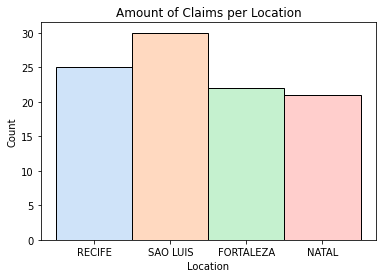

In [377]:
# Visualize the distribution of claims across different locations
sns.histplot(data=claims, x='Location', hue='Location', legend=False, palette='pastel').set(title='Amount of Claims per Location')
plt.show()

It seems that the number of claims are highest in Sao Luis at 30.61% and Lowest in Natal at 21.43%. With the other two other locations; Recife and Fortaleza, each having 25.51% and 22.45% respectively. There definitely appears to be a difference in the number of claims each location handles but the difference is slightly under 10%

<b>Qstn 2. What is the distribution of time to close claims?</b>

To answer this question, lets analyze the comparison between how long it takes to close a claim across the four different locations while maintaining the same order as the number of claims per locations above

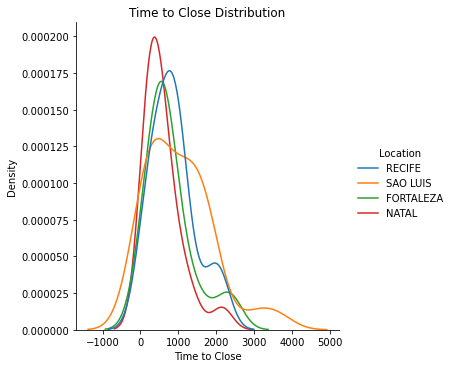

In [ ]:
# Lets visualize the distribution of the Time to Close data
sns.displot(data=claims, x='Time to Close', kind='kde', hue='Location').set(title='Time to Close Distribution')
plt.show()

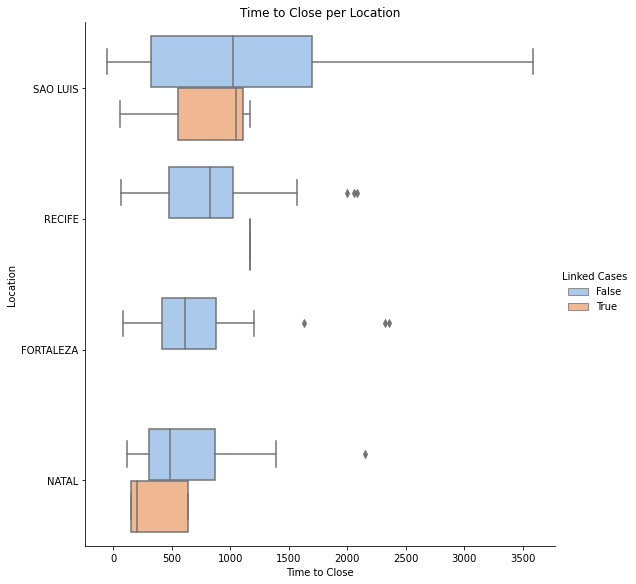

In [ ]:
# Lets visualize the time to close data categorised into different cases
sns.catplot(
    data=claims, 
    x='Time to Close', 
    y='Location', 
    kind='box',
    hue='Linked Cases',
    order=claim_num.index,
    palette='pastel',
    height=8
).set(title='Time to Close per Location')
plt.show()

We can observe how right skewed our distribution is across all locations due to the outliers. 

Observations:
- There is a pattern that annotates that the locations with a higher number of claims generally take a longer time to close.
- There is a difference between how quick cases that are linked to another case and those that are not linked to another case are closed. Sao Luis takes a longer time to close linked cases compared to Natal that closes linked cases faster than non-linked cases

<b>Qstn 3. How does the average time to close claims differ by location?</b>

Based on our above finding lets explore deeper how varied the average time to close is in different locations. The mean, is greatly affected by outliers and so in this case we will use the median to attain a more accurate figure. Lets view our full summary statistics.

In [ ]:
claims['Time to Close'].describe()

count      98.000000
mean      832.346939
std       686.851131
min       -57.000000
25%       340.750000
50%       638.500000
75%      1138.750000
max      3591.000000
Name: Time to Close, dtype: float64

In [ ]:
# Grouping our data to find the average time to close in each location
avg_time_to_close = claims.groupby(by='Location')['Time to Close'].agg('median').sort_values(ascending=False).to_frame(name='(Avg)Time to Close')
avg_time_to_close

,(Avg)Time to Close
Location,
SAO LUIS,1037.5
RECIFE,875.0
FORTALEZA,611.0
NATAL,477.0


In [ ]:
avg_time_to_close.columns

Index(['(Avg)Time to Close'], dtype='object')

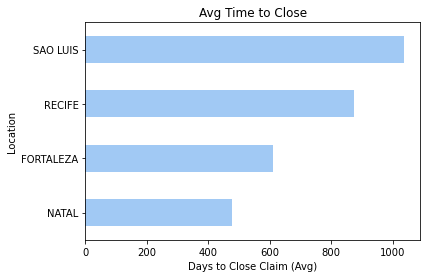

In [ ]:
claims.groupby(by='Location')['Time to Close'].median().sort_values().plot(kind='barh', color='#a1c9f4', title='Avg Time to Close')
plt.xlabel('Days to Close Claim (Avg)')
plt.show()

As we can see, the average time to close a claim within the whole Vivendo Company is about 638 days. The locations with a higher number of claims still seem to have a higher average time to close, with Sao Luis and Natal being the most and least locations in average time, respectively

<b>Bonus:</b> Is there any correlation between any two variables in our data? Lets find the correlation of each column and analyze our findings

In [ ]:
claims.corr()

,Time to Close,Claim Amount,Amount Paid,Individuals on Claim,Linked Cases
Time to Close,1.000000,-0.122153,-0.174050,-0.126452,-0.117329
Claim Amount,-0.122153,1.000000,0.870107,0.999240,0.871404
Amount Paid,-0.174050,0.870107,1.000000,0.868906,0.801807
Individuals on Claim,-0.126452,0.999240,0.868906,1.000000,0.870925
Linked Cases,-0.117329,0.871404,0.801807,0.870925,1.000000


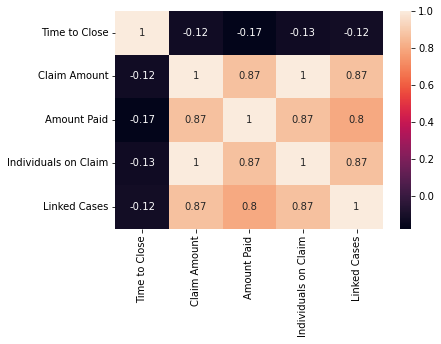

In [ ]:
sns.heatmap(claims.corr(), annot=True)
plt.show()

There appears to be a correlation between the Claim Amount and the Individuals on Claim, with a high correlation coefficient of 0.999240, lets plot this specific correlation on a scatterplot

<AxesSubplot:xlabel='Claim Amount', ylabel='Individuals on Claim'>

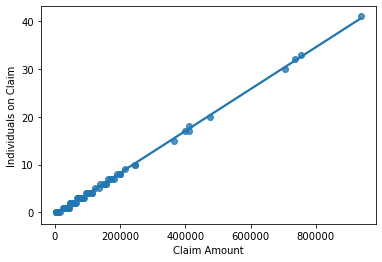

In [ ]:
sns.regplot(data=claims, x='Claim Amount', y='Individuals on Claim', ci=None)

We can spot a pattern between the correlation between the Claim Amount and the Individuals on Claim that has a perfect positive correlation coefficient. Which means an increase in the number of Individuals on the Claim increases the Claim Amount paid